# Training & Evaluation of Several Filters

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## Load Training and Test Data

In [133]:
file_dir = '../data/processed2/'
filename = 'NA12878.LowSeq.illumina.bwa.sorted.dedup.20.sam.wFlag.qual.recalibrated.filtered.noNAN.scaled.withGndTruthLabels'
train_file = file_dir + filename + '.train.table'
test_file = file_dir + filename + '.test.table'

df_train_full = pd.read_csv(train_file, sep='\t')
df_test = pd.read_csv(test_file, sep='\t')

In [134]:
df_train_full.columns

Index([u'Unnamed: 0', u'QUAL', u'AC', u'AF', u'DP', u'FS', u'MLEAC', u'MLEAF',
       u'MQ', u'QD', u'SOR', u'sample1.DP', u'sample1.GQ', u'FILTER',
       u'GROUND_TRUTH'],
      dtype='object')

In [135]:
df_train_full = df_train_full.drop('Unnamed: 0', axis=1)
df_test = df_test.drop('Unnamed: 0', axis=1)
#df_train_full = df_train_full.drop(['Unnamed: 0', 'sample1.PL', 'sample1.AD', 'sample1.GT', 'REF', 'ALT', 'ID', 'CHROM', 'POS'], axis=1)
#df_train_full = df_train_full.drop([], axis=1)

## Split train into train and dev, and split into X and Y

In [ ]:
num_train = df_train_full.shape[0]
idx_train_dev = train_test_split(range(num_train), range(num_train), test_size = 0.3)
idx_train = idx_train_dev[0]
idx_dev = idx_train_dev[1]

In [144]:
df_train = df_train_full.loc[idx_train,:]
df_dev = df_train_full.loc[idx_dev,:]

df_train_Y = df_train['GROUND_TRUTH']
df_train_X = df_train.drop(['GROUND_TRUTH'], axis=1)

df_dev_Y = df_dev['GROUND_TRUTH']
df_dev_X = df_dev.drop(['GROUND_TRUTH'], axis=1)

df_test_Y = df_test['GROUND_TRUTH']
df_test_X = df_test.drop(['GROUND_TRUTH'], axis=1)

df_train_full_Y = df_train_full['GROUND_TRUTH']
df_train_full_X = df_train_full.drop(['GROUND_TRUTH'], axis=1)

In [142]:
def sensitivity_specificity(labels, predictions):
    fpr, tpr, thresholds = roc_curve(labels, predictions, pos_label=1)
    return tpr[1], 1-fpr[1]

# Evaluate VQSR Performance

In [197]:
LOW_QUAL = 'LowQual'
TRANCHE_99_9 = 'VQSRTrancheSNP99.90to100.00' # low VQSLOD values in this tranche. need to use
            # a low VQSLOD threshold such that we get a 99.9-100% recovery 
TRANCHE_99 = 'VQSRTrancheSNP99.00to99.90' # medium VQSLOD values.
PASS_ALL = 'PASS'  # high VQSLOD values. recovers at most 99% of variants. so these are higher confidence calls

def did_variant_pass_filter(label, tranche):
    return label == PASS_ALL or \
            (tranche == TRANCHE_99 and label == TRANCHE_99) or \
            (tranche == TRANCHE_99_9 and (label == TRANCHE_99_9 or label == TRANCHE_99_9))
            
def convert_vqsr_labels(raw_labels, tranche=None):
    num_labels = raw_labels.shape[0]
    labels = num_labels * [0]
    for i, label in enumerate(raw_labels):
        if did_variant_pass_filter(label, tranche):
            labels[i] = 1
    return labels        

In [198]:
vqsr_dev_labels = df_dev_X['FILTER']
vqsr_test_labels = df_test_X['FILTER']
vqsr_tranches_uniq = set(df_dev_X['FILTER'])

if LOW_QUAL in vqsr_tranches_uniq:
    vqsr_tranches_uniq -= {LOW_QUAL}

vqsr_tranches_uniq = list(vqsr_tranches_uniq)    

vqsr_sens = np.zeros(len(vqsr_tranches_uniq))
vqsr_spec = np.zeros(len(vqsr_tranches_uniq))

for i, tranche in enumerate(vqsr_tranches_uniq):
    print 'Tranche: ', tranche
    vqsr_dev_labels_binary = convert_vqsr_labels(vqsr_dev_labels, tranche)
    vqsr_dev_acc = accuracy_score(df_dev_Y, vqsr_dev_labels_binary)
    print 'VQSR Dev Accuracy: ', vqsr_dev_acc
    vqsr_test_labels_binary = convert_vqsr_labels(vqsr_test_labels, tranche)
    vqsr_test_acc = accuracy_score(df_test_Y, vqsr_test_labels_binary)
    print 'VQSR Test Accuracy: ', vqsr_test_acc
    
    vqsr_sens[i], vqsr_spec[i] = sensitivity_specificity(df_test_Y, vqsr_test_labels_binary)
    print 'Sensitivity: ', vqsr_sens[i]
    print 'Specificity: ', vqsr_spec[i]
    

Tranche:  VQSRTrancheSNP99.90to100.00
VQSR Dev Accuracy:  0.828974063717
VQSR Test Accuracy:  0.829885233946
Sensitivity:  0.939998153789
Specificity:  0.286072486893
Tranche:  VQSRTrancheSNP99.00to99.90
VQSR Dev Accuracy:  0.925974666886
VQSR Test Accuracy:  0.925574789851
Sensitivity:  0.969168282101
Specificity:  0.710280373832
Tranche:  PASS
VQSR Dev Accuracy:  0.917804463453
VQSR Test Accuracy:  0.91931831267
Sensitivity:  0.922643773655
Specificity:  0.9028949168


### TODO: Consider using VQSLOD to obtain AUC Score. Issue is that sometimes the VQSLOD is NAN

## Remove VQSR Filter label so that we can run non-VQSR methods

In [140]:
df_train_X = df_train_X.drop(['FILTER'], axis=1)
df_dev_X = df_dev_X.drop(['FILTER'], axis=1)
df_train_full_X = df_train_full_X.drop(['FILTER'], axis=1)
df_test_X = df_test_X.drop(['FILTER'], axis=1)

# Supervised Learning Approaches

In [ ]:
# Number of folds for cross validation
num_folds = 10

## Logistic Regression

In [92]:
loss_function = 'l2'  # Loss function to use. Must be either 'l1' or 'l2'
lr_params = {'C':np.logspace(-4, 4, 20)}
lr_obj = linear_model.LogisticRegression(penalty=loss_function)

# Note: GridSearchCV will automatically use Stratified k-fold CV if the labels are binary and 
# the 'cv' parameter is an int
lr_classifier = GridSearchCV(lr_obj, lr_params, cv=num_folds)
lr_classifier.fit(df_train_X, df_train_Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   2.63665e-04,   6.95193e-04,   1.83298e-03,
         4.83293e-03,   1.27427e-02,   3.35982e-02,   8.85867e-02,
         2.33572e-01,   6.15848e-01,   1.62378e+00,   4.28133e+00,
         1.12884e+01,   2.97635e+01,   7.84760e+01,   2.06914e+02,
         5.45559e+02,   1.43845e+03,   3.79269e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [93]:
lr_best_est = lr_classifier.best_estimator_
print 'Logistic Regression Best Score: ', lr_classifier.best_score_
print 'Logistic Regression Best Estimator: ', lr_best_est
lr_dev_score = lr_classifier.score(df_dev_X, df_dev_Y)
print 'Logistic Regression Score on Dev Set: ', lr_dev_score

Logistic Regression Best Score:  0.942753742392
Logistic Regression Best Estimator:  LogisticRegression(C=29.763514416313132, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Logistic Regression Score on Dev Set:  0.942424740911


In [ ]:
"""
lr_pred_test = lr_cv_L2.predict(df_test_X)
#conf_lr_cv = lr_cv.decision_function(x_te)
lr_prob_scores_test = lr_cv_L2.predict_proba(df_test_X)
lr_prob_of_pos_test = lr_prob_scores_test[:, 1]

lr_auc_test = roc_auc_score(df_test_Y, lr_prob_of_pos_test)
lr_acc_test = accuracy_score(df_test_Y, lr_pred_test)
print 'AUC: ', lr_auc_test
print 'Accuracy: ', lr_acc_test
"""

## Support Vector Classifier. Train using 10-fold stratified CV with grid search for hyperparameter selection. 

In [67]:
svc_params = {'C':[1, 10, 100, 1000], 'gamma':[0.01, 0.1]}
svc_obj = SVC(kernel='rbf')
#cv_generator = StratifiedKFold(n_splits=10)

# Note: GridSearchCV will automatically use Stratified k-fold CV if the labels are binary and 
# the 'cv' parameter is an int
svc_classifier = GridSearchCV(svc_obj, svc_params, cv=num_folds)
svc_classifier.fit(df_train_X, df_train_Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [73]:
svc_best_est = svc_classifier.best_estimator_
print 'SVC Best Score: ', svc_classifier.best_score_
print 'SVC Best Estimator: ', svc_best_est
svc_dev_score = svc_classifier.score(df_dev_X, df_dev_Y)
print 'SVC Score on Dev Set: ', svc_dev_score

SVC Best Score:  0.951660282471
SVC Best Estimator:  SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
SVC Score on Dev Set:  0.951143280145


## Random Forest Classifier. Train using 10-fold stratified CV with grid search for hyperparameter selection. 

In [76]:
rf_params = {"n_estimators":[10, 20], "criterion": ["gini", "entropy"]}
rf_obj = RandomForestClassifier()

rf_classifier = GridSearchCV(rf_obj, rf_params, cv=num_folds)
rf_classifier.fit(df_train_X, df_train_Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [77]:
rf_best_est = rf_classifier.best_estimator_
print 'Rand Forest Best Score: ', rf_classifier.best_score_
print 'Rand Forest Best Estimator: ', rf_best_est
rf_dev_score = rf_classifier.score(df_dev_X, df_dev_Y)
print 'Rand Forest Score on Training Set: ', rf_dev_score

Rand Forest Best Score:  0.958945315254
Rand Forest Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Rand Forest Score on Training Set:  0.958381312716


# Evaluate classifiers on test set. First, we need to retrain classifiers on full dataset using optimal parameters that we found above using cross validation

## Logistic Regression

In [141]:
lr_classifier_full = linear_model.LogisticRegression(penalty=loss_function, C=lr_best_est.C)
lr_classifier_full.fit(df_train_full_X, df_train_full_Y) 
lr_pred_test = lr_classifier_full.predict(df_test_X)
lr_score_test = lr_classifier_full.score(df_test_X, df_test_Y)
print 'Logistic Regression Test Score: ', svc_score_test

Logistic Regression Test Score:  0.943614938779


In [120]:
lr_sens, lr_spec = sensitivity_specificity(df_test_Y, lr_pred_test)
print 'Sensitivity: ', lr_sens
print 'Specificity: ', lr_spec

 Sensitivity:  0.983245638327
Specificity:  0.721221791657


## SVC

In [83]:
svc_classifier_full = SVC(kernel='rbf', gamma=svc_best_est.gamma)
svc_classifier_full.fit(df_train_full_X, df_train_full_Y) 
svc_pred_test = svc_model_full.predict(df_test_X)
svc_score_test = svc_classifier_full.score(df_test_X, df_test_Y)
print 'SVC Test Score: ', svc_score_test

SVC Test Score:  0.943614938779


In [121]:
svc_sens, svc_spec = sensitivity_specificity(df_test_Y, svc_pred_test)
print 'Sensitivity: ', svc_sens
print 'Specificity: ', svc_spec

Sensitivity:  0.983245638327
Specificity:  0.751538636882


## Random Forest

In [88]:
rf_model_full = RandomForestClassifier(n_estimators=rf_best_est.n_estimators, criterion=rf_best_est.criterion)
rf_model_full.fit(df_train_full_X, df_train_full_Y)
rf_pred_test = rf_model_full.predict(df_test_X)
rf_score_test = rf_model_full.score(df_test_X, df_test_Y)
print 'Random Forest Test Score: ', rf_score_test

Random Forest Test Score:  0.959467239857


In [122]:
rf_sens, rf_spec = sensitivity_specificity(df_test_Y, rf_pred_test)
print 'Sensitivity: ', rf_sens
print 'Specificity: ', rf_spec

Sensitivity:  0.983245638327
Specificity:  0.85001139731


# Plot the Results

In [190]:
methods = ['VQSR', 'LogReg', 'RndFor', 'SVM']
colors = ['b', 'g', 'r', 'c']
vqsr_tranche_idx = 1

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

## Plot Sensitivity

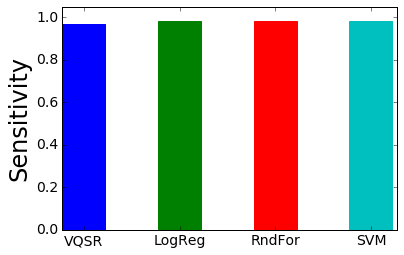

In [199]:
plt.figure()

sensitivities = [vqsr_sens[vqsr_tranche_idx], lr_sens, rf_sens, svc_sens]
ind = np.arange(len(methods))  # the x locations for the groups
width = 0.45       # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(ind, sensitivities, width)
for i,c in enumerate(colors):
    rects[i].set_color(c)

ax.set_xticks(ind + width/2)
ax.set_xticklabels((methods))

plt.ylim([0.0, 1.05])
plt.ylabel('Sensitivity', fontsize=24)
plt.show()


## Plot Specificity

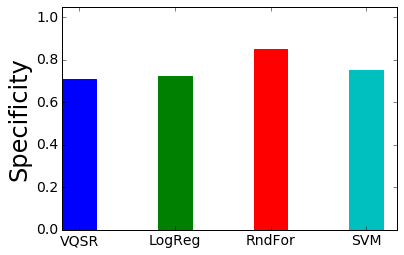

In [200]:
plt.figure()

specificities = [vqsr_spec[vqsr_tranche_idx], lr_spec, rf_spec, svc_spec]
ind = np.arange(len(methods))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(ind, specificities, width)
for i,c in enumerate(colors):
    rects[i].set_color(c)

ax.set_xticks(ind + width/2)
ax.set_xticklabels((methods))

plt.ylim([0.0, 1.05])
plt.ylabel('Specificity', fontsize=24)
plt.show()

In [ ]:
## Below is old code

In [104]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(df_test_Y, rf_pred_test, pos_label=1)
rf_roc_auc = auc(rf_fpr, rf_tpr)

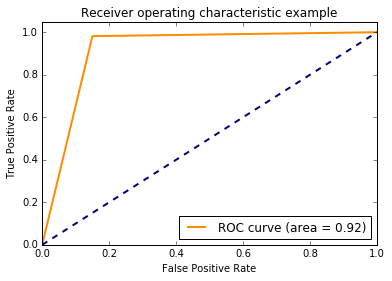

In [106]:
plt.figure()
lw = 2
plt.plot(rf_fpr, rf_tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [107]:
rf_tpr

array([ 0.       ,  0.9816302,  1.       ])

In [108]:
rf_thresholds

array([2, 1, 0])

In [109]:
rf_fpr

array([ 0.       ,  0.1499886,  1.       ])

AttributeError: 'numpy.ndarray' object has no attribute 'find'